In [129]:
from pymongo import MongoClient
from rates.gdax import Gdax
from rates.bithumb import Bithumb
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


In [130]:
db = MongoClient().bitcoinPremium.rates
data = db.find().sort("_id")

forex = [ key for key in db.find_one() if key not in ['_id', 'usd'] ]

L = {}

for fx in forex:
    L[fx] = []
    B = []
    for x in data:
        try:
            if x["usd"] and x[fx]:
                premium = (x[fx] / x["usd"]) - 1
                premium = round(premium * 100, 2)
                L[fx].append([int(x["_id"]), premium])
                B.append([int(x["_id"]), x["usd"]])
        except:
            pass

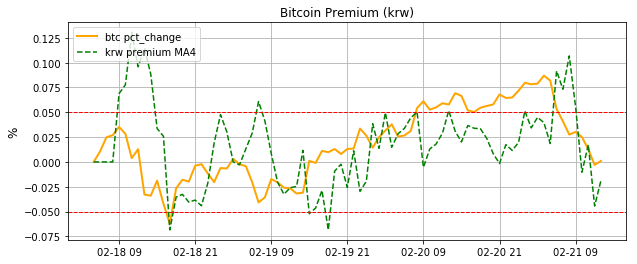

In [132]:
df = {}
premium = {}

bf = pd.DataFrame(B, columns=['timestamp','price'])
bf['timestamp'] = bf.timestamp + 28800
bf['date'] = pd.to_datetime(bf['timestamp'],unit='s')    
bf = bf.set_index("date")
bf.drop('timestamp', axis=1, inplace=True)

# bf["log"] = np.log2(bf.price.fillna(0))
bf["change"] = bf.price.pct_change().cumsum().fillna(0)

for fx in L:
    df[fx] = pd.DataFrame(L[fx], columns=['timestamp','premium'])
    df[fx]['timestamp'] = df[fx].timestamp + 28800
    df[fx]['date'] = pd.to_datetime(df[fx]['timestamp'],unit='s')    
    df[fx] = df[fx].set_index("date")
    df[fx].drop('timestamp', axis=1, inplace=True)
    df[fx].name = fx
    
    ma_length = 4
    premium[fx] = df[fx].premium.pct_change().rolling(ma_length).mean().fillna(0)
    
    plt.figure(figsize=(10,4))
    plt.plot(bf.change, ls='-', lw=2, c='orange', label='btc pct_change')
    plt.plot(premium[fx], ls='--', lw=1.5, c='green', label="%s premium MA%s" % (fx, ma_length))
    plt.grid(True)
    plt.legend(loc=2)
    plt.title('Bitcoin Premium (%s)' % fx, fontsize=12)
    plt.ylabel('%', fontsize=12)

    plt.axhline(y=0.05, color='red', linestyle='--', lw=1)
    plt.axhline(y=-0.05, color='red', linestyle='--', lw=1)
    
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    
    fig1.savefig('premium_%s.png' % fx, dpi=100)